<div class="alert alert-success">
    <h1>Session 2: Optimization, Batch Normalization, and Softmax</h1>
    <h3 align='center'>Computational Intelligence (4032-01)</h3>
    <h5 align='center'>Instructor: Dr.Samane Hosseini</h5>
    <h5 align='center'>TA: Arash Azhand</h5>
</div>

**This tutorial covers:**

1. Introduction to Optimization Algorithms (Adam, SGD)

2. Using Mini-Batches and Their Impact

3. Batch Normalization Concept and Implementation

4. Softmax for Multi-Class Classification

5. Solving the Problem with Advanced Techniques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(86)
np.random.seed(86)

Using device: cuda


# 1. Introduction to Optimization Algorithms (Adam, SGD)

Optimization algorithms are crucial for training neural networks. We'll compare SGD and Adam optimizers.

### Load Dataset and Transform

In [2]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), # Converts the PIL image or NumPy array into a PyTorch tensor.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    # First tuple is the mean for each color chanel, Second tuple is the standard deviation for each channel
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


### Define a simple CNN model

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) # to flatten the feature map before feeding it to FC.
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Training Function

In [4]:
def train_model(optimizer, model, train_loader, test_loader, epochs=10, optimizer_name='SGD'):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Optimizer: {optimizer_name}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return train_losses, test_accuracies

### Prepare data loaders

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Compare SGD and Adam

In [6]:
model_sgd = SimpleCNN().to(device)
model_adam = SimpleCNN().to(device)

# SGD with momentum
sgd_optimizer = SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
# Adam
adam_optimizer = Adam(model_adam.parameters(), lr=0.001)

In [7]:
print("Training with SGD:")
sgd_losses, sgd_accuracies = train_model(sgd_optimizer, model_sgd, train_loader, test_loader, epochs=10, optimizer_name='SGD')

print("\nTraining with Adam:")
adam_losses, adam_accuracies = train_model(adam_optimizer, model_adam, train_loader, test_loader, epochs=10, optimizer_name='Adam')

Training with SGD:
Epoch 1/10, Optimizer: SGD, Loss: 2.0467, Test Accuracy: 36.30%
Epoch 2/10, Optimizer: SGD, Loss: 1.6499, Test Accuracy: 46.82%
Epoch 3/10, Optimizer: SGD, Loss: 1.4299, Test Accuracy: 51.83%
Epoch 4/10, Optimizer: SGD, Loss: 1.3192, Test Accuracy: 53.56%
Epoch 5/10, Optimizer: SGD, Loss: 1.2430, Test Accuracy: 55.01%
Epoch 6/10, Optimizer: SGD, Loss: 1.1763, Test Accuracy: 58.73%
Epoch 7/10, Optimizer: SGD, Loss: 1.1146, Test Accuracy: 59.07%
Epoch 8/10, Optimizer: SGD, Loss: 1.0604, Test Accuracy: 62.07%
Epoch 9/10, Optimizer: SGD, Loss: 1.0124, Test Accuracy: 62.84%
Epoch 10/10, Optimizer: SGD, Loss: 0.9648, Test Accuracy: 64.81%

Training with Adam:
Epoch 1/10, Optimizer: Adam, Loss: 1.2710, Test Accuracy: 65.81%
Epoch 2/10, Optimizer: Adam, Loss: 0.8745, Test Accuracy: 70.34%
Epoch 3/10, Optimizer: Adam, Loss: 0.6804, Test Accuracy: 72.05%
Epoch 4/10, Optimizer: Adam, Loss: 0.5151, Test Accuracy: 73.27%
Epoch 5/10, Optimizer: Adam, Loss: 0.3590, Test Accuracy: 7

### Plot results

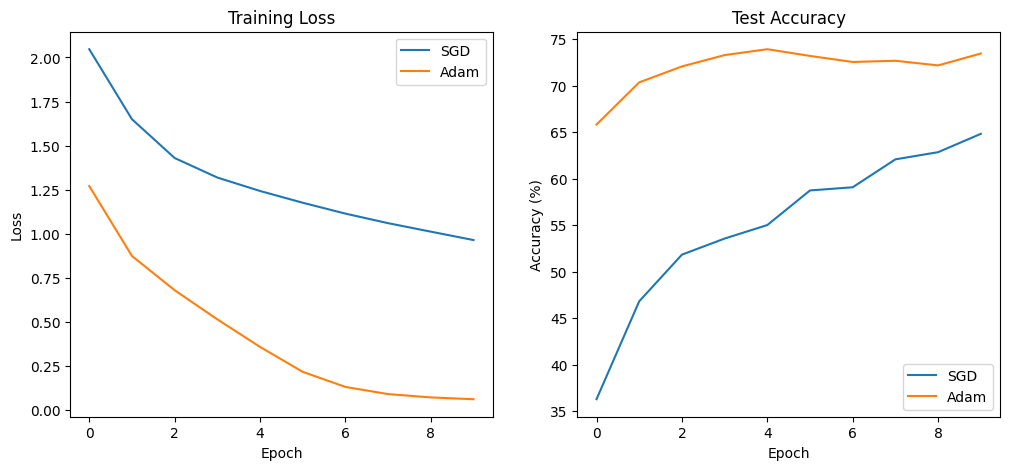

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sgd_losses, label='SGD')
plt.plot(adam_losses, label='Adam')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_accuracies, label='SGD')
plt.plot(adam_accuracies, label='Adam')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

* Adam typically converges faster than SGD

* SGD with momentum can sometimes generalize better

* Adam is less sensitive to learning rate choices



# 2. Mini-Batches and Their Impact


Training with batch size: 32
Epoch 1/10, Optimizer: Adam (BS=32), Loss: 1.2399, Test Accuracy: 65.55%
Epoch 2/10, Optimizer: Adam (BS=32), Loss: 0.8586, Test Accuracy: 70.77%
Epoch 3/10, Optimizer: Adam (BS=32), Loss: 0.6559, Test Accuracy: 72.45%
Epoch 4/10, Optimizer: Adam (BS=32), Loss: 0.4773, Test Accuracy: 73.19%
Epoch 5/10, Optimizer: Adam (BS=32), Loss: 0.3112, Test Accuracy: 73.39%
Epoch 6/10, Optimizer: Adam (BS=32), Loss: 0.1928, Test Accuracy: 72.78%
Epoch 7/10, Optimizer: Adam (BS=32), Loss: 0.1252, Test Accuracy: 73.00%
Epoch 8/10, Optimizer: Adam (BS=32), Loss: 0.1041, Test Accuracy: 72.64%
Epoch 9/10, Optimizer: Adam (BS=32), Loss: 0.0933, Test Accuracy: 71.33%
Epoch 10/10, Optimizer: Adam (BS=32), Loss: 0.0703, Test Accuracy: 72.12%

Training with batch size: 64
Epoch 1/10, Optimizer: Adam (BS=64), Loss: 1.2833, Test Accuracy: 61.45%
Epoch 2/10, Optimizer: Adam (BS=64), Loss: 0.8923, Test Accuracy: 69.03%
Epoch 3/10, Optimizer: Adam (BS=64), Loss: 0.7038, Test Accurac

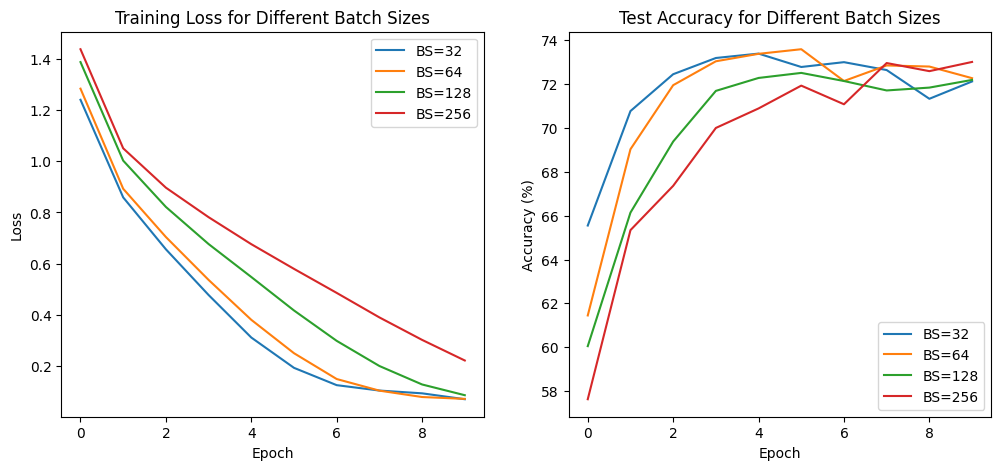

In [10]:
# Define batch sizes to test
batch_sizes = [32, 64, 128, 256]

# Dictionary to store results
results = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    losses, accuracies = train_model(optimizer, model, train_loader, test_loader, epochs=10, optimizer_name=f'Adam (BS={batch_size})')
    results[batch_size] = {'loss': losses, 'accuracy': accuracies}

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for bs, data in results.items():
    plt.plot(data['loss'], label=f'BS={bs}')
plt.title('Training Loss for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for bs, data in results.items():
    plt.plot(data['accuracy'], label=f'BS={bs}')
plt.title('Test Accuracy for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

* Smaller batches often lead to noisier updates but can generalize better

* Larger batches train faster per epoch but may require more epochs

* Very large batches can sometimes lead to poorer generalization

# 3. Batch Normalization Concept and Implementation

**Batch Normalization helps with training deeper networks by normalizing layer inputs.**

### CNN model with Batch Normalization

In [11]:
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

Training without Batch Normalization:
Epoch 1/15, Optimizer: No BN, Loss: 1.2669, Test Accuracy: 65.24%
Epoch 2/15, Optimizer: No BN, Loss: 0.8809, Test Accuracy: 69.75%
Epoch 3/15, Optimizer: No BN, Loss: 0.6926, Test Accuracy: 71.84%
Epoch 4/15, Optimizer: No BN, Loss: 0.5229, Test Accuracy: 72.98%
Epoch 5/15, Optimizer: No BN, Loss: 0.3619, Test Accuracy: 72.53%
Epoch 6/15, Optimizer: No BN, Loss: 0.2237, Test Accuracy: 72.56%
Epoch 7/15, Optimizer: No BN, Loss: 0.1312, Test Accuracy: 72.57%
Epoch 8/15, Optimizer: No BN, Loss: 0.0911, Test Accuracy: 73.28%
Epoch 9/15, Optimizer: No BN, Loss: 0.0700, Test Accuracy: 72.38%
Epoch 10/15, Optimizer: No BN, Loss: 0.0641, Test Accuracy: 72.34%
Epoch 11/15, Optimizer: No BN, Loss: 0.0614, Test Accuracy: 71.86%
Epoch 12/15, Optimizer: No BN, Loss: 0.0489, Test Accuracy: 72.41%
Epoch 13/15, Optimizer: No BN, Loss: 0.0482, Test Accuracy: 71.60%
Epoch 14/15, Optimizer: No BN, Loss: 0.0478, Test Accuracy: 71.37%
Epoch 15/15, Optimizer: No BN, Lo

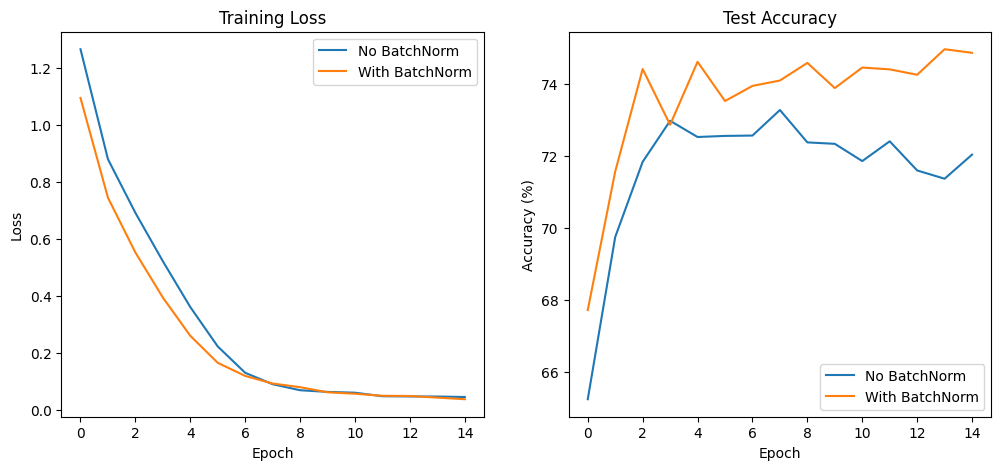

In [13]:
# Compare models with and without BN
model_no_bn = SimpleCNN().to(device)
model_with_bn = CNNWithBN().to(device)

# Same optimizer for both
optimizer_no_bn = Adam(model_no_bn.parameters(), lr=0.001)
optimizer_with_bn = Adam(model_with_bn.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Training without Batch Normalization:")
no_bn_losses, no_bn_accuracies = train_model(optimizer_no_bn, model_no_bn, train_loader, test_loader, epochs=15, optimizer_name="No BN")
print("\nTraining with Batch Normalization:")
with_bn_losses, with_bn_accuracies = train_model(optimizer_with_bn, model_with_bn, train_loader, test_loader, epochs=15, optimizer_name='With BN')


# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(no_bn_losses, label='No BatchNorm')
plt.plot(with_bn_losses, label='With BatchNorm')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(no_bn_accuracies, label='No BatchNorm')
plt.plot(with_bn_accuracies, label='With BatchNorm')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

* BatchNorm typically leads to faster convergence

* Helps with vanishing/exploding gradients

* Makes the network less sensitive to initialization

* Often allows for higher learning rates

# 4. Softmax for Multi-Class Classification

**Softmax is used in the output layer for multi-class classification. PyTorch's CrossEntropyLoss includes Softmax.**

In [14]:
model = CNNWithBN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
train_model(optimizer, model, train_loader, test_loader, epochs=10)

Epoch 1/10, Optimizer: SGD, Loss: 1.0816, Test Accuracy: 64.72%
Epoch 2/10, Optimizer: SGD, Loss: 0.7335, Test Accuracy: 71.75%
Epoch 3/10, Optimizer: SGD, Loss: 0.5432, Test Accuracy: 72.73%
Epoch 4/10, Optimizer: SGD, Loss: 0.3808, Test Accuracy: 74.93%
Epoch 5/10, Optimizer: SGD, Loss: 0.2491, Test Accuracy: 74.71%
Epoch 6/10, Optimizer: SGD, Loss: 0.1648, Test Accuracy: 73.16%
Epoch 7/10, Optimizer: SGD, Loss: 0.1130, Test Accuracy: 73.66%
Epoch 8/10, Optimizer: SGD, Loss: 0.0859, Test Accuracy: 73.67%
Epoch 9/10, Optimizer: SGD, Loss: 0.0750, Test Accuracy: 73.82%
Epoch 10/10, Optimizer: SGD, Loss: 0.0662, Test Accuracy: 73.34%


([1.0816487884887345,
  0.733486056442151,
  0.543241217980147,
  0.380793408855148,
  0.2490640149339843,
  0.16484708855848026,
  0.11297811239319461,
  0.08593624356128943,
  0.07504619400748207,
  0.06619675287529064],
 [64.72, 71.75, 72.73, 74.93, 74.71, 73.16, 73.66, 73.67, 73.82, 73.34])

In [15]:
# Get some test samples
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

In [16]:
# Get model outputs
model.eval()
with torch.no_grad():
    outputs = model(images)

In [17]:
# Apply softmax to outputs
softmax = nn.Softmax(dim=1)
probs = softmax(outputs)

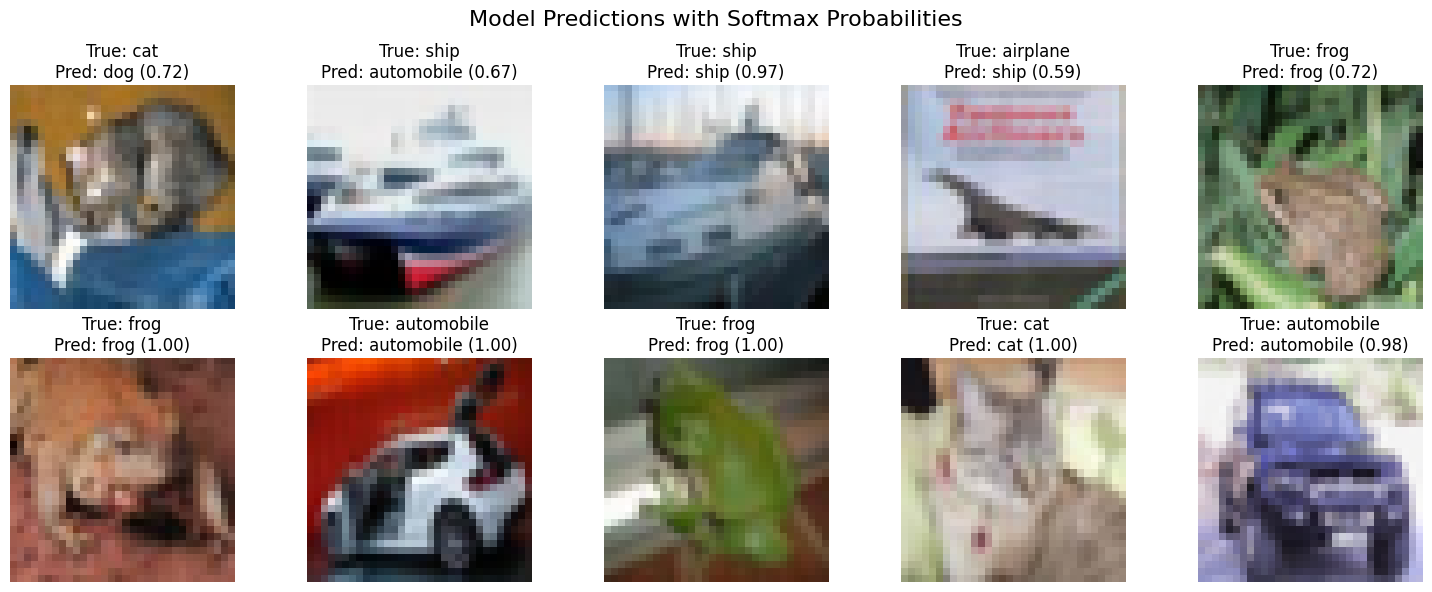

In [19]:
# Display some predictions
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Model Predictions with Softmax Probabilities', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i >= 10:
        break
    image = images[i].cpu().numpy().transpose((1, 2, 0))
    image = image * 0.5 + 0.5  # Unnormalize

    ax.imshow(image)
    pred_class = torch.argmax(probs[i]).item()
    true_class = labels[i].item()

    ax.set_title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]} ({probs[i][pred_class]:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()



In [20]:
# Print classification report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.76      0.77      1000
  automobile       0.82      0.89      0.85      1000
        bird       0.70      0.54      0.61      1000
         cat       0.58      0.51      0.54      1000
        deer       0.76      0.64      0.69      1000
         dog       0.58      0.75      0.66      1000
        frog       0.65      0.90      0.75      1000
       horse       0.91      0.70      0.79      1000
        ship       0.81      0.84      0.82      1000
       truck       0.85      0.80      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



# 5. Enhanced CNN model with all techniques

Techniques Used:

1. Deeper CNN architecture

2. Batch Normalization after each convolutional layer

3. Dropout for regularization

4. Data augmentation (random flips, rotations, translations)

5. Adam optimizer with weight decay (L2 regularization)

6. Learning rate scheduling

7. Proper mini-batch training

In [21]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [22]:
# Initialize model, loss, and optimizer
model = EnhancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added L2 regularization
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

In [24]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
# Reload datasets with augmentation
train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset_aug, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_aug, batch_size=128, shuffle=False)

In [26]:
# Training loop with all techniques
num_epochs = 25
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch 1/25, Loss: 1.3351, Test Accuracy: 61.24%
Epoch 2/25, Loss: 0.9359, Test Accuracy: 73.60%
Epoch 3/25, Loss: 0.8071, Test Accuracy: 71.80%
Epoch 4/25, Loss: 0.7290, Test Accuracy: 79.47%
Epoch 5/25, Loss: 0.6828, Test Accuracy: 80.82%
Epoch 6/25, Loss: 0.6276, Test Accuracy: 82.72%
Epoch 7/25, Loss: 0.5988, Test Accuracy: 84.05%
Epoch 8/25, Loss: 0.5639, Test Accuracy: 84.33%
Epoch 9/25, Loss: 0.5444, Test Accuracy: 85.06%
Epoch 10/25, Loss: 0.5180, Test Accuracy: 85.45%
Epoch 11/25, Loss: 0.4286, Test Accuracy: 87.88%
Epoch 12/25, Loss: 0.3990, Test Accuracy: 88.62%
Epoch 13/25, Loss: 0.3863, Test Accuracy: 88.59%
Epoch 14/25, Loss: 0.3706, Test Accuracy: 88.76%
Epoch 15/25, Loss: 0.3616, Test Accuracy: 89.05%
Epoch 16/25, Loss: 0.3537, Test Accuracy: 89.06%
Epoch 17/25, Loss: 0.3496, Test Accuracy: 89.06%
Epoch 18/25, Loss: 0.3403, Test Accuracy: 89.43%
Epoch 19/25, Loss: 0.3368, Test Accuracy: 89.42%
Epoch 20/25, Loss: 0.3329, Test Accuracy: 89.75%
Epoch 21/25, Loss: 0.3151, Te

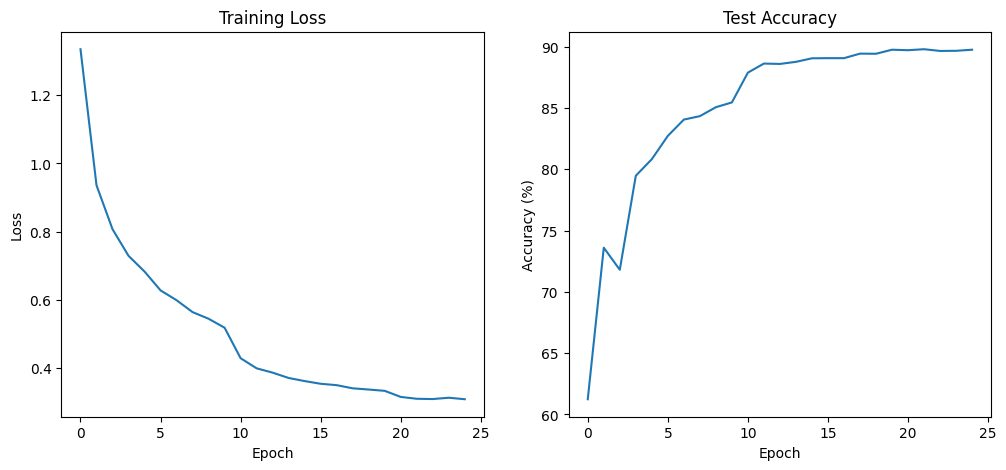

In [27]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [28]:
# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nFinal Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Final Classification Report:
              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.96      0.95      0.95      1000
        bird       0.86      0.84      0.85      1000
         cat       0.83      0.73      0.78      1000
        deer       0.87      0.92      0.89      1000
         dog       0.82      0.85      0.83      1000
        frog       0.92      0.94      0.93      1000
       horse       0.94      0.93      0.94      1000
        ship       0.92      0.95      0.94      1000
       truck       0.93      0.95      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

